In [1]:
import os
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization,Activation, concatenate, DepthwiseConv2D, Multiply,Dropout
from keras.layers import GlobalAveragePooling2D, Dense, MaxPooling2D,Flatten, Layer,BatchNormalization, Add,Reshape,AveragePooling2D

from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from keras.optimizers import Adam


from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt



In [2]:
input_shape = (224, 224, 3)

test_dir = '/root/BreastCancer/BCResize/100X/test'
train_dir = '/root/BreastCancer/BCResize/100X/train'


batch_size = 32
num_classes = 2
# filter_factor = 8

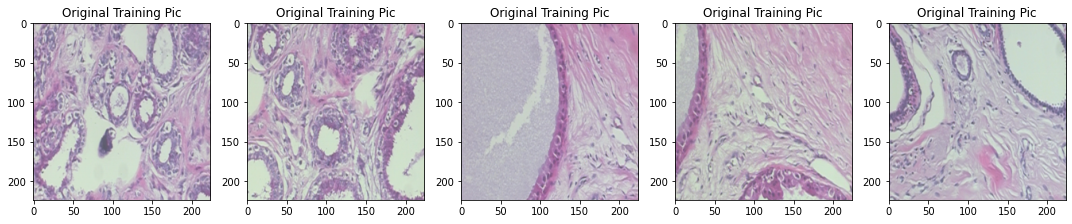

In [3]:
train_diabetic = '/root/BreastCancer/BCResize/100X/test/benign'

#Show the import original image
train_img_files = os.listdir(train_diabetic)
# test_img_files = os.listdir(test_dir)
# val_img_files = os.listdir(val_dir)

show_num = 5

plt.figure(figsize = (15, 5))

for i in range(show_num):
    
    img_path = os.path.join(train_diabetic, train_img_files[i])
    img = plt.imread(img_path)
    plt.subplot(1, show_num, i + 1)
    plt.imshow(img)
    plt.axis('on')
    plt.title("Original Training Pic")
    
plt.tight_layout()
plt.show()


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.13,  # Specify the validation split here
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1.0/255)

# Load and preprocess the training and testing images
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 'training' subset for training data
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 'validation' subset for validation data
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical'
)


Found 2129 images belonging to 2 classes.
Found 316 images belonging to 2 classes.
Found 311 images belonging to 2 classes.


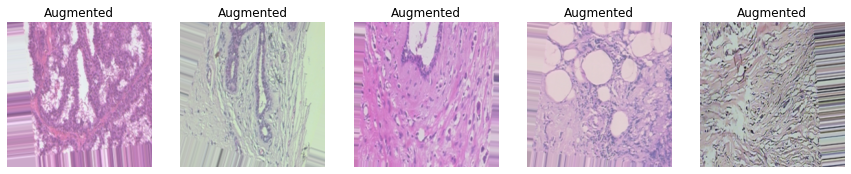

In [5]:
#To show the augmented pictures, after rotation, zoom in, rescale etc

# import scipy

# Extract a batch of images from the train_generator
sample_images, sample_labels = next(train_generator)

plt.figure(figsize = (15, 5))

# Show the original images from the batch
num_images_to_show = 5  # Show three images
for i in range(num_images_to_show):
    plt.subplot(1, num_images_to_show, i + 1)
    plt.imshow(sample_images[i-1])
    plt.title("Augmented")
    plt.axis('off')

<h1>Model Construction<h1>

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, GlobalAveragePooling2D, Dense

def resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Input Convolution
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu', kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    # Residual Blocks
    for filters in [64, 128, 64, 128]:
        # Residual connection
        identity = x

        # Adjust the number of filters in identity to match x if necessary
        if identity.shape[-1] != filters:
            identity = Conv2D(filters, (1, 1), padding='same', activation='relu', kernel_initializer='he_normal')(identity)
            identity = BatchNormalization()(identity)

        # First Convolution
        x = Conv2D(filters, (3, 3), padding='same', activation='relu', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)

        # Second Convolution
        x = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(x)
        x = BatchNormalization()(x)

        # Add Residual Connection
        x = Add()([x, identity])
        x = Activation('relu')(x)

        # Optional: Additional MaxPooling
        x = MaxPooling2D((2, 2), strides=(2, 2), padding='same')(x)

    # Global Average Pooling
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model



# Create the ResNet model
model = resnet(input_shape, num_classes)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

2023-12-24 17:39:12.174553: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-24 17:39:12.706778: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22307 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


                                                                                                  
 batch_normalization_3 (BatchNo  (None, 28, 28, 128)  512        ['conv2d_3[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 add_1 (Add)                    (None, 28, 28, 128)  0           ['batch_normalization_5[0][0]',  
                                                                  'batch_normalization_3[0][0]']  
                                                                                                  
 activation_1 (Activation)      (None, 28, 28, 128)  0           ['add_1[0][0]']                  
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 14, 14, 128)  0          ['activation_1[0][0]']           
          

In [7]:
lr = 0.001
Optimizer = Adam(learning_rate = lr)

from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow_addons.metrics import F1Score
from tensorflow.keras import backend as K


model.compile(
    optimizer='adam',
    loss = "categorical_crossentropy",
    metrics=[
        "accuracy", 
        Precision(), 
        Recall(), 
        AUC(), 
        F1Score(num_classes=2, average = 'micro')
    ]
)

MODEL_NAME = "ResNet100XResized"  # 用您的模型名替换
# 训练合并后的模型
csv_logger = tf.keras.callbacks.CSVLogger(
    fr"/root/BreastCancer/CSVHistory/2. ResNet/{MODEL_NAME}.csv", 
    separator=",", 
    append=False)

lr_reduction = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1,
                                patience = 10,
                                min_lr = 0.00001,
                                verbose = 1)





In [8]:
history = model.fit(
    train_generator,
    epochs=100,  # 根据需要调整epochs数
    validation_data=validation_generator,
    callbacks=[csv_logger, lr_reduction]  # 添加 ModelCheckpoint 到回调列表
)

Epoch 1/100


2023-12-24 17:39:17.108692: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2023-12-24 17:39:18.538945: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


67/67 [==============================] - 29s 377ms/step - loss: 0.5060 - accuracy: 0.7647 - precision: 0.7647 - recall: 0.7647 - auc: 0.8506 - f1_score: 0.7647 - val_loss: 0.7851 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5000 - val_auc: 0.5362 - val_f1_score: 0.5000 - lr: 0.0010
Epoch 2/100
67/67 [==============================] - 24s 362ms/step - loss: 0.3881 - accuracy: 0.8253 - precision: 0.8253 - recall: 0.8253 - auc: 0.9091 - f1_score: 0.8253 - val_loss: 1.8541 - val_accuracy: 0.5380 - val_precision: 0.5380 - val_recall: 0.5380 - val_auc: 0.4150 - val_f1_score: 0.5380 - lr: 0.0010
Epoch 3/100
67/67 [==============================] - 25s 370ms/step - loss: 0.3391 - accuracy: 0.8473 - precision: 0.8473 - recall: 0.8473 - auc: 0.9294 - f1_score: 0.8473 - val_loss: 0.8607 - val_accuracy: 0.1804 - val_precision: 0.1804 - val_recall: 0.1804 - val_auc: 0.1025 - val_f1_score: 0.1804 - lr: 0.0010
Epoch 4/100
67/67 [==============================] - 24s 362ms/step - los

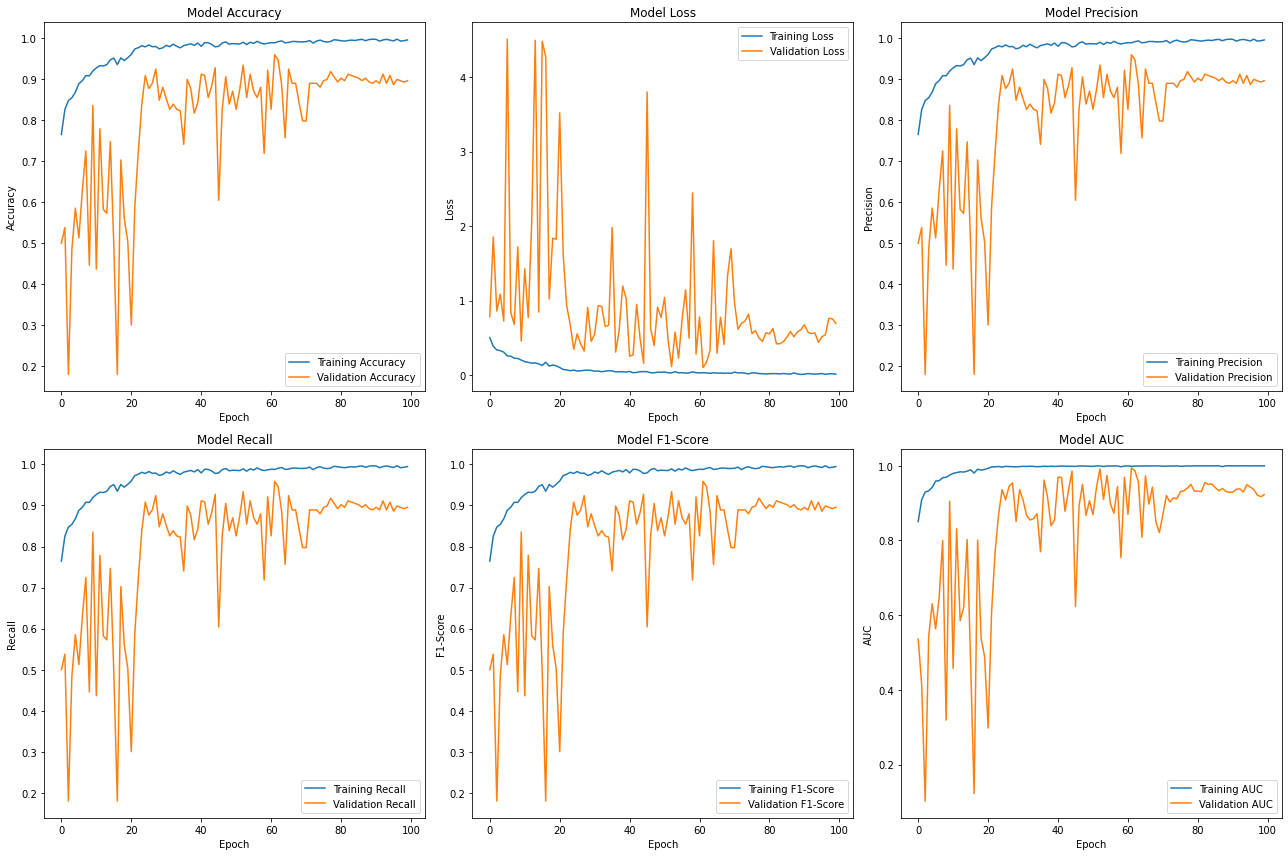

In [9]:
plt.figure(figsize=(18, 12))

plt.subplot(2, 3, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='lower right')

plt.subplot(2, 3, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper right')

plt.subplot(2, 3, 3)
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('Model Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Training Precision', 'Validation Precision'], loc='lower right')


plt.subplot(2, 3, 4)
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Training Recall', 'Validation Recall'], loc='lower right')

plt.subplot(2, 3, 5)
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1-Score')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend(['Training F1-Score', 'Validation F1-Score'], loc='lower right')

plt.subplot(2, 3, 6)
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend(['Training AUC', 'Validation AUC'], loc='lower right')

plt.tight_layout()
plt.show()

9/9 [==============================] - 0s 22ms/step


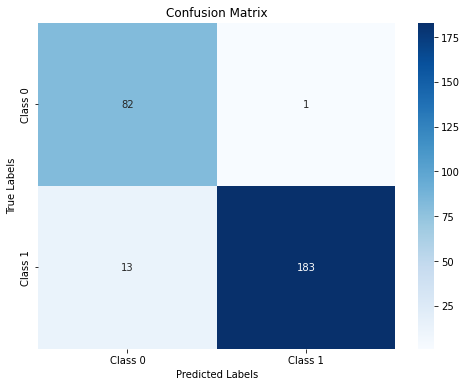

In [11]:
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 收集图像和真实标签
all_images, all_true_labels = zip(*[next(test_generator) for _ in range(test_generator.samples // test_generator.batch_size)])
all_images = np.concatenate(all_images)
all_true_labels = np.argmax(np.concatenate(all_true_labels), axis=1)

# 进行预测并获取预测标签
predictions = model.predict(all_images)
predicted_labels = np.argmax(predictions, axis=1)

# 生成并绘制混淆矩阵
conf_matrix = confusion_matrix(all_true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()


In [12]:
from sklearn.metrics import f1_score


# 计算F1-Score
f1 = f1_score(all_true_labels, predicted_labels, average='macro')

print("F1-Score:", f1)


f1_each_class = f1_score(all_true_labels, predicted_labels, average=None)
print("F1-Score for each class:", f1_each_class)


F1-Score: 0.9422531046717919
F1-Score for each class: [0.92134831 0.96315789]


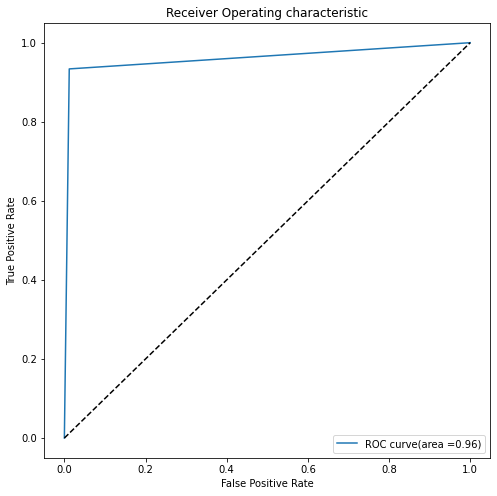

In [13]:
#compute precision-recall score
from sklearn.metrics import roc_curve, auc

#compute precision, recall(sensitivity), and threshold values
fpr, tpr, thresholds = roc_curve(all_true_labels, predicted_labels)

#compute the AUC score
roc_auc= auc(fpr, tpr)

#plot the precision-recall curve
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label= 'ROC curve(area =%0.2f)' %roc_auc)
plt.plot([0, 1], [0,1], 'k--')
plt.title('Receiver Operating characteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

In [14]:
#compute sensitivity and specificity
sensitivity=tpr[1] #True positive rate 
specificity= 1-fpr[1]

print('sensitivity:', sensitivity)
print('specificity:', specificity)

sensitivity: 0.9336734693877551
specificity: 0.9879518072289156


9/9 [==============================] - 0s 8ms/step


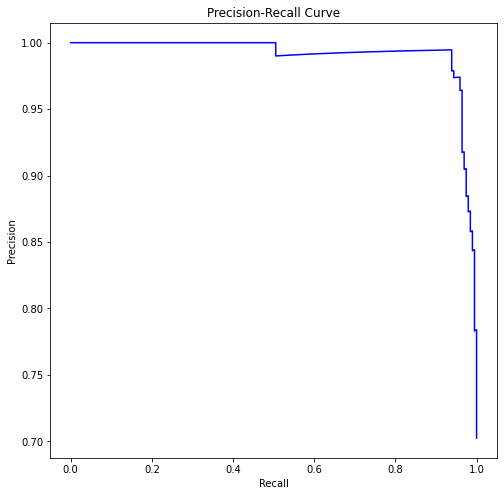

In [15]:
from sklearn.metrics import precision_recall_curve

# 计算预测概率
ensemble_pred_probs = model.predict(all_images)

# 获取预测正类的概率
# 假设是二分类问题，并且正类是第二个类别
positive_class_probs = ensemble_pred_probs[:, 1]

# 计算 Precision 和 Recall
precision, recall, thresholds = precision_recall_curve(all_true_labels, positive_class_probs)

plt.figure(figsize=(8, 8))
plt.plot(recall, precision, color='b')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [16]:
test_loss, test_acc, test_precision, test_recall, test_auc, test_f1_score = model.evaluate(test_generator)
print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print('Test precision:', test_precision)
print('Test recall:', test_recall)
print('Test AUC:', test_auc)
print('Test F1 Score:', test_f1_score)

10/10 [==============================] - 1s 75ms/step - loss: 0.3184 - accuracy: 0.9550 - precision: 0.9550 - recall: 0.9550 - auc: 0.9650 - f1_score: 0.9550
Test loss: 0.3184003531932831
Test accuracy: 0.9549839496612549
Test precision: 0.9549839496612549
Test recall: 0.9549839496612549
Test AUC: 0.9649919867515564
Test F1 Score: 0.9549839496612549


In [17]:
from sklearn.metrics import classification_report

# 使用模型对验证集进行预测，获取预测概率
y_pred_probs = model.predict(all_images)

# 将预测概率转换为类别标签
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# 假设 y_val 是真实标签，并且也是类别标签形式
# 现在您可以生成分类报告
report = classification_report(all_true_labels, y_pred_labels)
print(report)


9/9 [==============================] - 0s 8ms/step
              precision    recall  f1-score   support

           0       0.86      0.99      0.92        83
           1       0.99      0.93      0.96       196

    accuracy                           0.95       279
   macro avg       0.93      0.96      0.94       279
weighted avg       0.96      0.95      0.95       279



In [19]:
#delete the model to prevent memory costs

from keras import backend as K
import gc

K.clear_session()
gc.collect()

del model


from numba import cuda

cuda.select_device(0)
cuda.close()